# In this Notebook we are going to Fine tune a T5 fundation LLM model with your own data


Model

https://huggingface.co/docs/transformers/model_doc/t5


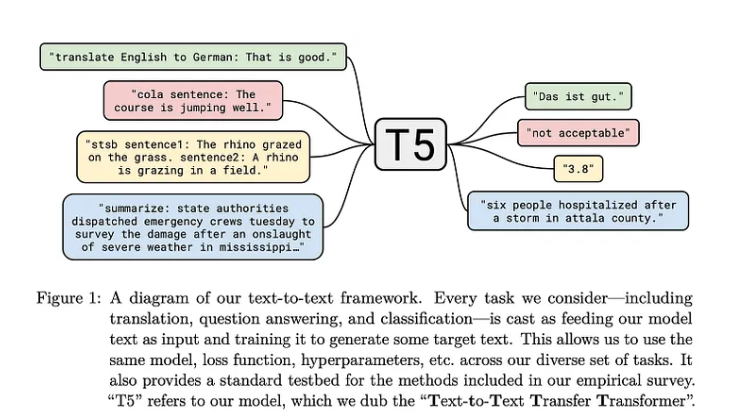


https://arxiv.org/pdf/1910.10683.pdf

https://huggingface.co/google/flan-t5-base


from Cameron R. Wolfe, Ph.D.

https://towardsdatascience.com/t5-text-to-text-transformers-part-one-6b655f27c79a#:~:text=T5%20converts%20all%20text%20processing,tasks%20with%20a%20shared%20approach.

# fine tuned flan-T5

https://blog.research.google/2021/10/introducing-flan-more-generalizable.html

https://huggingface.co/docs/transformers/model_doc/flan-t5

https://arxiv.org/pdf/2210.11416.pdf

https://www.narrativa.com/flan-t5-a-yummy-model-superior-to-gpt-3/

# Flan Dataset

https://medium.com/dair-ai/papers-explained-46-flan-1c5e0d5db7c9


# Dataset use for Fine Tuning

https://www.kaggle.com/datasets/jensenbaxter/10dataset-text-document-classification

# Final Dataset

Microsoft Purview -- > https://learn.microsoft.com/en-us/purview/classifier-tc-definitions#trainable-classifiers-definitions


In [1]:
! pip install  evaluate==0.4.1 wandb -q 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/documents-raw/documents_raw.csv


# Create Dataset

In [4]:

from datasets import ClassLabel, Dataset, Features, Image, Value, Sequence, DatasetDict
label_dic={"business":0,"entertainment":1,"food":2,"graphics":3,"historical":4,"medical":5,"politics":6,"space":7,"sport":8,"technologie":9}


Clabels= ClassLabel(num_classes=10, names=["business","entertainment","food","graphics","historical","medical","politics","space","sport","technologie"])


df = pd.read_csv("/kaggle/input/documents-raw/documents_raw.csv")
df = df[["Class", "Document"]]
df['label2']= df['Class'].map(label_dic)

In [5]:
df.head(2)

,Class,Document,label2
0,space,series linked messages periodically posted att...,7
1,space,article according iau circular comet may tempo...,7


In [7]:
list_text= df["Document"].to_list()
list_labels=df["Class"].to_list()
list_labels2=df["label2"].to_list()

In [9]:
stratify_column_name = "label2"
dtrain= { "text": list_text, "label2": list_labels2, "label":list_labels}
dataset = Dataset.from_dict(mapping=dtrain, features=Features({"text":  Value(dtype='string', id=None), "label2": Value(dtype='int8'), 'label': Value(dtype='string', id=None)}))

dataset = dataset.shuffle(seed=42)
dataset = dataset.class_encode_column(stratify_column_name).train_test_split(test_size=0.3)
dataset = dataset.cast_column("label2", Clabels)

Stringifying the column:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label2', 'label'],
        num_rows: 700
    })
    test: Dataset({
        features: ['text', 'label2', 'label'],
        num_rows: 300
    })
})

In [16]:
import evaluate
import nltk
import numpy as np
import torch
from typing import List, Tuple
from nltk.tokenize import sent_tokenize
from datasets import Dataset, concatenate_datasets
from huggingface_hub import HfFolder
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    T5Tokenizer,
    T5ForConditionalGeneration
)

MODEL_ID = "sentence-transformers/gtr-t5-large"

In [13]:
dataset['train'][1]

{'text': 'market unfazed aurora aurora limped back dock 20 blizzard photos interviews seemed add unambiguous tale ship another slice bad luck add history health scares technical cruises part huge us carnival corporation looking significant slice chopped profits potential pr seems told stock warning hit 2005 earnings came 24 hours one biggest investment banks upped target share investors barely 1300 gmt shares london single mismatch public perception aurora issue ongoing one says deutsche simon clearly source uncertainty company long stock market good treating issues string bad pointed aurora one vessel large carnival princess group merged much larger us firm generally carnival reputation keeping ships pretty much incredibly strong track mr analysts expect impact rest cruise business hundreds disappointed passengers give opportunity spend next three months aurora got refund credit another mitigate pr carnival main royal cancellations technical reasons entirely unusual wrote analysts cit

In [17]:
PROJECT = "FlanT5-Document-Classification"
MODEL_NAME = 'sentence-transformers/gtr-t5-large'
DATASET = "Kaggle-1000-Documents-10-classes"
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##### https://www.kaggle.com/datasets/jensenbaxter/10dataset-text-document-classification

Classes : business, entertainment,food, graphics, historical, medical, politics, space, sport, technologie


# Model
https://huggingface.co/docs/transformers/model_doc/t5


*Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer*

https://arxiv.org/pdf/1910.10683.pdf

In [19]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

wandb_key = user_secrets.get_secret("wandb_key")

In [20]:
import wandb
wandb.login(key=wandb_key)
with wandb.init(project=PROJECT,tags=[MODEL_NAME, DATASET],notes ="Fine tuning FlanT5 with Kaggle Dataset. 100 Documents 10 classes",job_type="dataset"): 
    wbtrain = wandb.Table(data=dataset['train'].to_pandas())
    wbtest = wandb.Table(data=dataset['test'].to_pandas())
    wandb.log({"dialogsum_train": wbtrain})
    wandb.log({"dialogsum_test": wbtest})


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: olonok (olonok69). Use `wandb login --relogin` to force relogin


In [21]:
len(dataset['test'].to_pandas()['label'].unique())

10

In [22]:
dataset['test'].to_pandas()['label'].value_counts()

label
technologie      39
sport            34
business         32
medical          31
historical       31
food             30
politics         29
space            26
entertainment    25
graphics         23
Name: count, dtype: int64

In [24]:
dataset['train'].to_pandas()['label'].value_counts()

label
graphics         77
entertainment    75
space            74
politics         71
food             70
historical       69
medical          69
business         68
sport            66
technologie      61
Name: count, dtype: int64

In [25]:
# https://huggingface.co/google/flan-t5-base

In [28]:
full = concatenate_datasets([dataset["train"], dataset["test"]])

In [29]:
full[:2]

{'text': ['film show documentary takes candid look life singer george michael shown berlin film different story screen panorama section runs features singer talking career personal days recent michael attend festival introduce screening 16 director southan morris executive producer andy stephens also attend 93 minute film see michael discussing early days along later including legal battles record label sony stance iraq war american also touch upon turbulent personal including arrest beverly hills park toilet 1998 death boyfriend anselmo feleppa includes previously unseen footage singer also features contributions former partner andrew well backing singers pepsi contributors include mariah elton noel geri halliwell simon festival open man historical epic starring joseph fiennes kristin one 21 films competing top golden films competition include life quirky comedy starring bill biopic features liam full programme announced 1',
  'market unfazed aurora aurora limped back dock 20 blizzard

In [30]:
# Metric
metric = evaluate.load("f1")

# Tokenizers

large language models process text using tokens, which are common sequences of characters found in a set of text. The models learn to understand the statistical relationships between these tokens, and excel at producing the next token in a sequence of tokens.

https://platform.openai.com/tokenizer

# Autotokenizer

https://huggingface.co/docs/transformers/v4.36.1/en/model_doc/auto#transformers.AutoTokenizer

In [31]:
MODEL_ID = "sentence-transformers/gtr-t5-large"
# # Load tokenizer of FLAN-t5
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)


tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

In [32]:
tokenized_inputs = concatenate_datasets([dataset["train"], dataset["test"]]).map(
    lambda x: tokenizer(x["text"], truncation=True), batched=True, remove_columns=[ 'label', 'label2']
)
max_source_length = max([len(x) for x in tokenized_inputs["input_ids"]])
print(f"Max source length: {max_source_length}")

  0%|          | 0/1 [00:00<?, ?ba/s]

Max source length: 512


In [34]:
tokenized_inputs[1]['text']

'market unfazed aurora aurora limped back dock 20 blizzard photos interviews seemed add unambiguous tale ship another slice bad luck add history health scares technical cruises part huge us carnival corporation looking significant slice chopped profits potential pr seems told stock warning hit 2005 earnings came 24 hours one biggest investment banks upped target share investors barely 1300 gmt shares london single mismatch public perception aurora issue ongoing one says deutsche simon clearly source uncertainty company long stock market good treating issues string bad pointed aurora one vessel large carnival princess group merged much larger us firm generally carnival reputation keeping ships pretty much incredibly strong track mr analysts expect impact rest cruise business hundreds disappointed passengers give opportunity spend next three months aurora got refund credit another mitigate pr carnival main royal cancellations technical reasons entirely unusual wrote analysts citigroup sm

In [35]:
tokenized_inputs[1]['input_ids']
len(tokenized_inputs[1]['input_ids'])
len(tokenized_inputs[1]['attention_mask'])

253

In [36]:
tokenizer("technologie")

{'input_ids': [3, 13148, 1], 'attention_mask': [1, 1, 1]}

In [37]:
# The maximum total sequence length for target text after tokenization.
# Sequences longer than this will be truncated, sequences shorter will be padded."
tokenized_targets = concatenate_datasets([dataset["train"], dataset["test"]]).map(
    lambda x: tokenizer(x["label"], truncation=True), batched=True, remove_columns=['text', 'label2']
)
max_target_length = max([len(x) for x in tokenized_targets["input_ids"]])
print(f"Max target length: {max_target_length}")

  0%|          | 0/1 [00:00<?, ?ba/s]

Max target length: 3


In [38]:
tokenized_targets['input_ids'][:10], full['label'][:10]

([[4527, 1],
  [268, 1],
  [4332, 1],
  [628, 1],
  [6525, 1],
  [3, 13148, 1],
  [6525, 1],
  [3, 13148, 1],
  [4527, 1],
  [2600, 1]],
 ['entertainment',
  'business',
  'historical',
  'space',
  'politics',
  'technologie',
  'politics',
  'technologie',
  'entertainment',
  'sport'])

In [40]:
REPOSITORY_ID = f"{MODEL_ID.split('/')[1]}-text-classification"

# Model

In [41]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_TOKEN")
# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=REPOSITORY_ID,
    per_device_train_batch_size=8,
    #per_device_eval_batch_size=8,
    predict_with_generate=True,
    fp16=False,     # Overflows with fp16
    learning_rate=3e-4,
    num_train_epochs=10,
    logging_dir=f"{REPOSITORY_ID}/logs",    # logging & evaluation strategies
    logging_strategy="epoch",
    evaluation_strategy="no",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=False,
    report_to="wandb",
    push_to_hub=False,
    hub_strategy="every_save",
    hub_model_id=REPOSITORY_ID,
    hub_token=user_secrets.get_secret("HF_TOKEN"),
)

def preprocess_function(sample: Dataset, max_target_length: int, padding: str = "max_length") -> dict:
    """ Preprocess the dataset. """

    # add prefix to the input for t5
    inputs = [item for item in sample["text"]]

    # tokenize inputs
    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text_target=sample["label"], max_length=max_target_length, padding=padding, truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


def postprocess_text(preds: List[str], labels: List[str]) -> Tuple[List[str], List[str]]:
    """ helper function to postprocess text"""
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(sent_tokenize(label)) for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, average='macro')
    result = {k: round(v * 100, 10) for k, v in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    return result

In [42]:
tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=['text', 'label','label2'],fn_kwargs={"max_target_length": max_target_length})
print(f"Keys of tokenized dataset: {list(tokenized_dataset['train'].features)}")

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Keys of tokenized dataset: ['input_ids', 'attention_mask', 'labels']


In [44]:
tokenized_dataset['train'][1].keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [46]:
tokenized_dataset['train'][1]['input_ids']
len(tokenized_dataset['train'][1]['input_ids'])

512

In [ ]:
#tokenized_dataset['train'][1]['attention_mask']

# AutoModelForSeq2SeqLM

This is a generic model class that will be instantiated as one of the model classes of the library—with a sequence-to-sequence language modeling head

https://huggingface.co/docs/transformers/model_doc/t5

https://huggingface.co/transformers/v3.5.1/model_doc/auto.html#automodelforseq2seqlm

In [47]:
labels = dataset['train'].features['label2'].names
id2label={str(i): c for i, c in enumerate(labels)}
label2id={c: str(i) for i, c in enumerate(labels)}
id2label

{'0': 'business',
 '1': 'entertainment',
 '2': 'food',
 '3': 'graphics',
 '4': 'historical',
 '5': 'medical',
 '6': 'politics',
 '7': 'space',
 '8': 'sport',
 '9': 'technologie'}

In [48]:
label2id

{'business': '0',
 'entertainment': '1',
 'food': '2',
 'graphics': '3',
 'historical': '4',
 'medical': '5',
 'politics': '6',
 'space': '7',
 'sport': '8',
 'technologie': '9'}

In [49]:
# load model from the hub
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_ID, num_labels=len(labels),
                                              torch_dtype=torch.bfloat16,
     id2label={str(i): c for i, c in enumerate(labels)},
     label2id={c: str(i) for i, c in enumerate(labels)},)

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/670M [00:00<?, ?B/s]

Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at sentence-transformers/gtr-t5-large and are newly initialized: ['decoder.block.13.layer.0.SelfAttention.q.weight', 'decoder.block.10.layer.0.layer_norm.weight', 'decoder.block.21.layer.1.EncDecAttention.o.weight', 'decoder.block.1.layer.0.layer_norm.weight', 'decoder.block.17.layer.2.layer_norm.weight', 'decoder.block.10.layer.0.SelfAttention.v.weight', 'decoder.block.21.layer.0.SelfAttention.v.weight', 'decoder.block.7.layer.2.DenseReluDense.wi.weight', 'decoder.block.12.layer.2.DenseReluDense.wi.weight', 'decoder.block.4.layer.1.layer_norm.weight', 'decoder.block.21.layer.0.layer_norm.weight', 'decoder.block.13.layer.2.DenseReluDense.wo.weight', 'decoder.block.2.layer.2.DenseReluDense.wo.weight', 'decoder.block.14.layer.0.layer_norm.weight', 'decoder.block.18.layer.2.DenseReluDense.wi.weight', 'decoder.block.16.layer.2.layer_norm.weight', 'decoder.block.16.layer.1.EncDecAttention.o.weight', 'd

# Data Collator

https://huggingface.co/docs/transformers/main/main_classes/data_collator

In [50]:
nltk.download("punkt")

# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [51]:
# Create Trainer instance
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset["train"],
    #eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)

In [52]:
tokenized_dataset["test"]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 300
})

In [53]:

import torch
import gc
gc.collect()
torch.cuda.empty_cache()

In [54]:
# TRAIN

with wandb.init(project=PROJECT, job_type="train"):
    train_results = trainer.train()
    trainer.save_model()

    trainer.log_metrics("train", train_results.metrics)
    trainer.save_metrics("train", train_results.metrics)
    trainer.save_state()
    print(train_results.metrics)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


Traceback (most recent call last):
  File "/tmp/ipykernel_43/3238063161.py", line 4, in <module>
    train_results = trainer.train()
  File "/opt/conda/lib/python3.10/site-packages/transformers/trainer.py", line 1537, in train
    return inner_training_loop(
  File "/opt/conda/lib/python3.10/site-packages/transformers/trainer.py", line 1854, in _inner_training_loop
    tr_loss_step = self.training_step(model, inputs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/trainer.py", line 2723, in training_step
    loss = self.compute_loss(model, inputs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/trainer.py", line 2746, in compute_loss
    outputs = model(**inputs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/t5/modeling_t5.py", line 1743, in forward
    decoder_outputs = self.decoder(
  File "/opt/

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.89 GiB total capacity; 15.38 GiB already allocated; 22.12 MiB free; 15.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
train_results

In [ ]:
!rm -rf /kaggle/working/flan-T5-fine-tune

In [ ]:

!mkdir /kaggle/working/flan-T5-fine-tune
custom_path = "/kaggle/working/flan-T5-fine-tune/"
trainer.save_model(output_dir=custom_path)

In [ ]:
with wandb.init(project=PROJECT, job_type="models"):
    artifact = wandb.Artifact("flan-T5-fine-tuned", type="model")
    artifact.add_dir(custom_path)
    wandb.save(custom_path)
    wandb.log_artifact(artifact)

In [ ]:
tokenizer.save_pretrained(REPOSITORY_ID)

# *Uncomment to push to HF*


In [ ]:
# tokenizer.save_pretrained(REPOSITORY_ID)
# trainer.create_model_card()
# trainer.push_to_hub()

In [ ]:
import torch
from tqdm.auto import tqdm


from sklearn.metrics import classification_report



# Load model and tokenizer from the hub
#tokenizer = AutoTokenizer.from_pretrained(f"/kaggle/working/{REPOSITORY_ID}")
tokenizer = T5Tokenizer.from_pretrained(f"/kaggle/working/{REPOSITORY_ID}")

#model = AutoModelForSeq2SeqLM.from_pretrained(custom_path)
model = T5ForConditionalGeneration.from_pretrained(custom_path, num_labels=len(labels),
     id2label={str(i): c for i, c in enumerate(labels)},
     label2id={c: str(i) for i, c in enumerate(labels)},)

model = model.to('cuda') if torch.cuda.is_available() else model.to('cpu')

In [ ]:
def classify(text_to_classify: str) -> str:
    """Classify a text using the model."""
    inputs = tokenizer.encode_plus(text_to_classify, padding='max_length', max_length=512, return_tensors='pt')
    inputs = inputs.to('cuda') if torch.cuda.is_available() else inputs.to('cpu')
    outputs = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=3)#, num_beams=4, early_stopping=True)
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return prediction


def evaluate_model() -> None:
    """Evaluate the model on the test dataset."""
    predictions_list, labels_list = [], []

    samples_number = len(dataset['test'])
    progress_bar = tqdm(range(samples_number))

    for i in range(samples_number):
        text = dataset['test']['text'][i]
        predictions_list.append(classify(text))
        labels_list.append(str(dataset['test']['label'][i]))

        progress_bar.update(1)

    report = classification_report(labels_list, predictions_list, zero_division=0)
    print(report)

In [ ]:
 evaluate_model()

In [ ]:
text_to_classify ="""As 2023 draws to a close, we’ve been looking back on the year as it unfolded in UK and world politics.

While many may have expected a quieter year in UK politics, the year of 2023 didn’t fail to keep the headlines flowing. Events in the UK also happened amid an already and increasingly challenging context in international politics, with new conflicts breaking out this year. Looking forward, 2024 is set to be a major year for politics, with two key elections expected in the UK and US, against a backdrop of significant challenges across the world. 

Month by month, this is a summary of some of the key political stories that got people talking, drove change and impacted people’s lives in 2023…

January
Strikes – The UK Government published a bill in Parliament designed to require organisations in the public sector to provide a minimum level of service in the event of strikes by workers. The move came during a month in which workers for various services walked out over numerous disputes – workers to strike included rail workers, NHS staff, DVLA staff, DWP staff, bus drivers, legal advisers and more. There was even greater impacts from strike action in March.

Gender Recognition Reform Bill – The UK Government announced it would block a bill passed by the Scottish Parliament seeking to make it simpler for people to change their legal gender. The bill was blocked under a section 35 order of the 1998 Scotland Act to stop the bill receiving royal assent – the first time such an order is thought to have been made.

International – Luiz Inácio Lula da Silva was sworn in as the President of Brazil."""

In [ ]:
from nltk.corpus import stopwords
import nltk

def pre_process_text(text_to_classify):
    tokens = text_to_classify.split(" ")
    tokens_pun_lower = [i.lower() for i in tokens if i.isalnum()]
    stop_words = stopwords.words('english')
    tokens_stop = [i for i in tokens_pun_lower if i not in stop_words]
    text_to_class = " ".join(tokens_stop)
    return text_to_class

In [ ]:
text_to_class = pre_process_text(text_to_classify)

In [ ]:
classify(text_to_class)